In [1]:
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

In [2]:
data_dir = '2021-07-19'

In [3]:
title_embs_df = pd.read_csv(f'scibert编码文章/title_embs_df_{data_dir}.csv',index_col=0)
abstract_embs_df = pd.read_csv(f'scibert编码文章/abstract_embs_df_{data_dir}.csv',index_col=0)
paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')

In [4]:
citation_net = pd.read_csv(f'scibert编码文章/citation_net_{data_dir}.tsv',sep='\t')

citing_pair = citation_net.loc[~(citation_net['citing_uid'].isna() | citation_net['cited_uid'].isna()) ][['citing_uid','cited_uid']]

citing_pair_set = set(map(lambda x:tuple(x),citing_pair.values))

non_citing_pairs = list(filter(lambda x: x not in citing_pair_set and x[0]!=x[1],map(lambda x:tuple(x),np.random.choice(list(paper_emb.index),size=147248*2).reshape(-1,2))))

In [5]:
# paper_uids = paper_emb.index.tolist()

In [6]:
del title_embs_df
del abstract_embs_df
del paper_emb
gc.collect()

40

In [7]:
embedding_dict = dict()

In [8]:
for method in ['tfidf', 'glove','scibert']:

    # SCIBERT Embedding
    if method == 'scibert':
        print('scibert')
        title_embs_df = pd.read_csv(f'scibert编码文章/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert编码文章/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        citing_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x],citing_pair['citing_uid'].tolist()))]
        cited_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x],citing_pair['cited_uid'].tolist()))]
        fake_citing_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x[0]],non_citing_pairs))]
        fake_cited_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x[1]],non_citing_pairs))]
        embedding_dict['scibert'] = [citing_uid_embeds, cited_uid_embeds, fake_citing_uid_embeds, fake_cited_uid_embeds]

    # Glove Embedding
    if method == 'glove':
        print('glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        citing_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x],citing_pair['citing_uid'].tolist()))]
        cited_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x],citing_pair['cited_uid'].tolist()))]
        fake_citing_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x[0]],non_citing_pairs))]
        fake_cited_uid_embeds = paper_emb.values[list(map(lambda x:uid_map[x[1]],non_citing_pairs))]
        embedding_dict['glove'] = [citing_uid_embeds, cited_uid_embeds, fake_citing_uid_embeds, fake_cited_uid_embeds]

    # TF-IDF Embedding
    if method == 'tfidf':
        print('tfidf')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        citing_uid_embeds = values[list(map(lambda x:uid_map[x],citing_pair['citing_uid'].tolist()))]
        cited_uid_embeds = values[list(map(lambda x:uid_map[x],citing_pair['cited_uid'].tolist()))]
        fake_citing_uid_embeds = values[list(map(lambda x:uid_map[x[0]],non_citing_pairs))]
        fake_cited_uid_embeds = values[list(map(lambda x:uid_map[x[1]],non_citing_pairs))]
        embedding_dict['tfidf'] = [citing_uid_embeds, cited_uid_embeds, fake_citing_uid_embeds, fake_cited_uid_embeds]

tfidf
glove
scibert


In [9]:
embedding_dict['tfidf']

[<147248x21154 sparse matrix of type '<class 'numpy.float64'>'
 	with 18838095 stored elements in Compressed Sparse Row format>,
 <147248x21154 sparse matrix of type '<class 'numpy.float64'>'
 	with 16303871 stored elements in Compressed Sparse Row format>,
 <147242x21154 sparse matrix of type '<class 'numpy.float64'>'
 	with 16004601 stored elements in Compressed Sparse Row format>,
 <147242x21154 sparse matrix of type '<class 'numpy.float64'>'
 	with 15957367 stored elements in Compressed Sparse Row format>]

In [10]:
citing_pair_dis_dict = dict()

In [11]:
for method, embeddings in embedding_dict.items():
    citing_uid_embeds, cited_uid_embeds, fake_citing_uid_embeds, fake_cited_uid_embeds = embeddings
    citing_pair_dis = {'l2':[],'cos':[]}
    for i in tqdm(range(citing_uid_embeds.shape[0])):
        citing_uid_emb, cited_uid_emb = citing_uid_embeds[i], cited_uid_embeds[i]
        l2_dis = np.linalg.norm((citing_uid_emb-cited_uid_emb) if isinstance(cited_uid_emb, np.ndarray) else (citing_uid_emb-cited_uid_emb).todense())
        if isinstance(cited_uid_emb, np.ndarray):
            cos_sim = (citing_uid_emb.dot(cited_uid_emb.T)) / (np.sqrt(citing_uid_emb.dot(citing_uid_emb.T)) * np.sqrt(cited_uid_emb.dot(cited_uid_emb.T)) +1e-10)
        else:
            cos_sim = np.array((citing_uid_emb.dot(cited_uid_emb.T)).todense())[0][0] / (np.array(np.sqrt(citing_uid_emb.dot(citing_uid_emb.T).todense()))[0][0] * np.array(np.sqrt(cited_uid_emb.dot(cited_uid_emb.T).todense()))[0][0] +1e-10)
        citing_pair_dis['l2'].append(l2_dis)
        citing_pair_dis['cos'].append(cos_sim)
    
    non_citing_pair_dis = {'l2':[],'cos':[]}
    for i in tqdm(range(fake_citing_uid_embeds.shape[0])):
        citing_uid_emb, cited_uid_emb = fake_citing_uid_embeds[i], fake_cited_uid_embeds[i]
        l2_dis = np.linalg.norm((citing_uid_emb-cited_uid_emb) if isinstance(cited_uid_emb, np.ndarray) else (citing_uid_emb-cited_uid_emb).todense())
        if isinstance(cited_uid_emb, np.ndarray):
            cos_sim = (citing_uid_emb.dot(cited_uid_emb.T)) / (np.sqrt(citing_uid_emb.dot(citing_uid_emb.T)) * np.sqrt(cited_uid_emb.dot(cited_uid_emb.T)) +1e-10)
        else:
            cos_sim = np.array((citing_uid_emb.dot(cited_uid_emb.T)).todense())[0][0] / (np.array(np.sqrt(citing_uid_emb.dot(citing_uid_emb.T).todense()))[0][0] * np.array(np.sqrt(cited_uid_emb.dot(cited_uid_emb.T).todense()))[0][0] +1e-10)
        non_citing_pair_dis['l2'].append(l2_dis)
        non_citing_pair_dis['cos'].append(cos_sim)
    
    citing_pair_dis_dict[method] = [citing_pair_dis, non_citing_pair_dis]

100%|████████████████████████████████████████████████████████████████████████| 147242/147242 [01:34<00:00, 1562.63it/s]


In [12]:
# citing_pair_dis = {'l2':[],'cos':[]}
# for _,row in tqdm(citing_pair.iterrows()):
#     print(f"1 {time.time()}")
#     citing_uid, cited_uid = row['citing_uid'], row['cited_uid']
# #     print(f"2 {time.time()}")
#     citing_uid_emb, cited_uid_emb = paper_emb_values[uid_map[citing_uid]], paper_emb_values[uid_map[cited_uid]]
#     print(f"3 {time.time()}")
#     l2_dis = np.linalg.norm(citing_uid_emb-cited_uid_emb)
# #     print(f"4 {time.time()}")
#     cos_sim = np.inner(citing_uid_emb, cited_uid_emb) / (np.linalg.norm(citing_uid_emb) * np.linalg.norm(cited_uid_emb) +1e-10)
#     print(f"5 {time.time()}")
#     citing_pair_dis['l2'].append(l2_dis)
#     citing_pair_dis['cos'].append(cos_sim)
#     print(f"6 {time.time()}")

In [13]:
# non_citing_pair_dis = {'l2':[],'cos':[]}
# for citing_uid,cited_uid in tqdm(non_citing_pairs):
#     citing_uid_emb, cited_uid_emb = paper_emb.loc[citing_uid].values, paper_emb.loc[cited_uid].values
#     l2_dis = np.linalg.norm(citing_uid_emb-cited_uid_emb)
#     cos_sim = np.inner(citing_uid_emb, cited_uid_emb) / (np.linalg.norm(citing_uid_emb) * np.linalg.norm(cited_uid_emb)+1e-10)
#     non_citing_pair_dis['l2'].append(l2_dis)
#     non_citing_pair_dis['cos'].append(cos_sim)

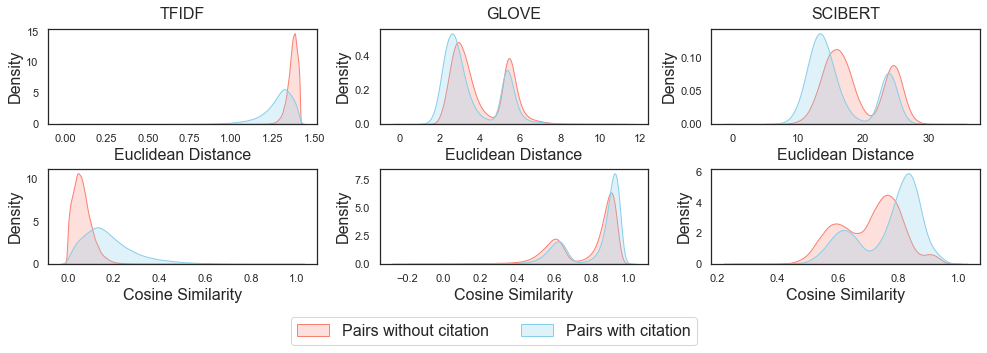

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,5))

cols = list(citing_pair_dis_dict.keys())
rows = ['Euclidean Distance', 'Cosine Similarity']
pad = 5 # in points
for ax, col in zip(axes[0], cols):
    ax.annotate(col.upper(), xy=(0.5, 1), xytext=(0, 2*pad), fontsize=16,
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline')

for idx, (method, dist) in enumerate(citing_pair_dis_dict.items()):
    
    citing_pair_dis, non_citing_pair_dis = dist

    zeros_cnt_citation = (np.array(citing_pair_dis['cos'])<=0).sum()
    zeros_cnt_fake = (np.array(non_citing_pair_dis['cos'])<=0).sum()

    sns.kdeplot(non_citing_pair_dis['l2'], fill=True, color="salmon", label='Pairs without citation', ax=axes[0][idx])
    sns.kdeplot(citing_pair_dis['l2'], fill=True, color="skyblue", label='Pairs with citation', ax=axes[0][idx])
#     loc = 'upper left' if method in ['tfidf'] else 'upper right'
#     axes[0][idx].legend(fontsize=12, loc=loc)
    axes[0][idx].set_xlabel('Euclidean Distance',fontsize=16)
    axes[0][idx].set_ylabel('Density',fontsize=16)

    sns.kdeplot(non_citing_pair_dis['cos'], fill=True, color="salmon",label='Pairs without citation', ax=axes[1][idx])
    sns.kdeplot(citing_pair_dis['cos'], fill=True, color="skyblue",label='Pairs with citation', ax=axes[1][idx])
    axes[1][idx].set_xlabel('Cosine Similarity',fontsize=16)
    axes[1][idx].set_ylabel('Density',fontsize=16)
#     loc = 'upper right' if method in ['tfidf'] else 'upper left'
#     axes[1][idx].legend(fontsize=12, loc=loc)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=16)
    
fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig('pair/citing_pair.jpg',dpi=500)

In [15]:


# if method == 'tfidf':
#     plt.text(0.6,7,f"Similarity ≤ 0 (N={zeros_cnt_citation})",fontsize=14,color='b')
#     plt.text(0.6,6,f"Similarity ≤ 0 (N={zeros_cnt_fake})",fontsize=14,color='r')
# if method == 'glove':
#     plt.text(-0.2,4,f"Similarity ≤ 0 (N={zeros_cnt_citation})",fontsize=14,color='b')
#     plt.text(-0.2,3,f"Similarity ≤ 0 (N={zeros_cnt_fake})",fontsize=14,color='r')
# if method == 'scibert':
#     plt.text(0.3,5,f"Similarity ≤ 0 (N={zeros_cnt_citation})",fontsize=14,color='b')
#     plt.text(0.3,4,f"Similarity ≤ 0 (N={zeros_cnt_fake})",fontsize=14,color='r')
    
# # plt.title(f'{method}')
# # fig.savefig(f'pair/citation-pair-distance-simlarity-distribution_{method}.png', dpi=200)

In [16]:
# plt.figure(figsize=(10,5))
# fig = sns.kdeplot(non_citing_pair_dis['cos'], shade=True, color="r",label='Fake Pair')
# fig = sns.kdeplot(citing_pair_dis['cos'], shade=True, color="b",label='Citation Pair')
# plt.legend()
# plt.show()